In [1]:
model_checkpoint = "facebook/dinov2-base" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
!pip install -q datasets transformers

In [3]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [8]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/dermnet")

Resolving data files:   0%|          | 0/19559 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
from datasets import load_metric

metric = load_metric("accuracy")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 19559
    })
})

In [11]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=23, names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'], id=None

In [12]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x472>,
 'label': 0}

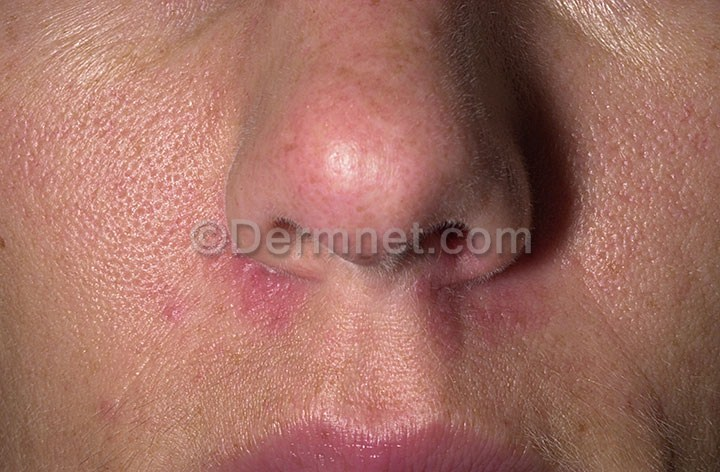

In [13]:
example['image']

In [14]:
example['label']

0

In [15]:
dataset["train"].features["label"]

ClassLabel(num_classes=23, names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'], id=None)

In [16]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Atopic Dermatitis Photos'

In [17]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [19]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [20]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [21]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x477>,
 'label': 3,
 'pixel_values': tensor([[[-0.3712, -0.6794, -0.7650,  ..., -0.6794, -0.5767, -0.8678],
          [-0.4397, -0.6281, -0.7650,  ..., -0.7308, -0.7308, -0.8678],
          [-0.5082, -0.5596, -0.6109,  ..., -0.7650, -0.7822, -0.8335],
          ...,
          [-0.2342, -0.1999, -0.1486,  ..., -0.1486, -0.2513, -0.2856],
          [-0.1999, -0.2171, -0.1999,  ..., -0.0972, -0.1999, -0.2684],
          [-0.1143, -0.1828, -0.2171,  ..., -0.1314, -0.1828, -0.2171]],
 
         [[-0.8102, -1.1253, -1.2129,  ..., -1.0553, -0.9503, -1.2304],
          [-0.8803, -1.0903, -1.2304,  ..., -1.1253, -1.1253, -1.2479],
          [-0.9678, -1.0203, -1.0728,  ..., -1.1954, -1.2129, -1.2479],
          ...,
          [-0.6352, -0.6176, -0.5476,  ..., -0.4426, -0.5476, -0.5651],
          [-0.6352, -0.6527, -0.6352,  ..., -0.3901, -0.4951, -0.5476],
          [-0.5476, -0.6176, -0.6527,  ..., -0.4076, -0.4776, -0.4951]]

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.33.3', '0.23.0')

In [24]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"dinov2-base-finetuned-dermnet",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=12,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [25]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [26]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,2.107800,1.923175,0.421268
1,1.728700,1.485888,0.566462
2,1.475000,1.317119,0.594581
4,1.148800,1.115040,0.665133
4,1.008200,1.026257,0.689162
5,0.753300,0.967348,0.706544
6,0.674100,0.921897,0.726994
8,0.568000,0.860700,0.751022
8,0.432700,0.823723,0.764315
9,0.346400,0.814343,0.764826


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
trainer.push_to_hub()

In [ ]:
test_ds

In [30]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score
import torch

# Load the pre-trained model and image processor
repo_name = "Jayanth2002/dinov2-base-rawdata-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/raw-paper/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms

# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data





Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-f0c83a64a00c9972/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9648
